In [2]:
import numpy as np
import pylab as plt
import hashlib
from regular_training.classifier_utils import cnn_model, load_from_directory, reduce_palette, change_pixel_values
from regular_training.classifier_utils import one_hot_encoding_to_label
from visualization_utils import visualize_convolutional_filters
from skimage import io, img_as_float, img_as_ubyte
import glob
import os
from keras.utils.np_utils import to_categorical
from keras import backend as K

%matplotlib inline

In [3]:
IMG_SIZE = 48
NUM_CLASSES = 10

In [4]:
X,Y = load_from_directory('train_set', IMG_SIZE, NUM_CLASSES) #loading and preprocessing images

/Users/pawelmorawiecki/tensorflow/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10 example images, each from one category:

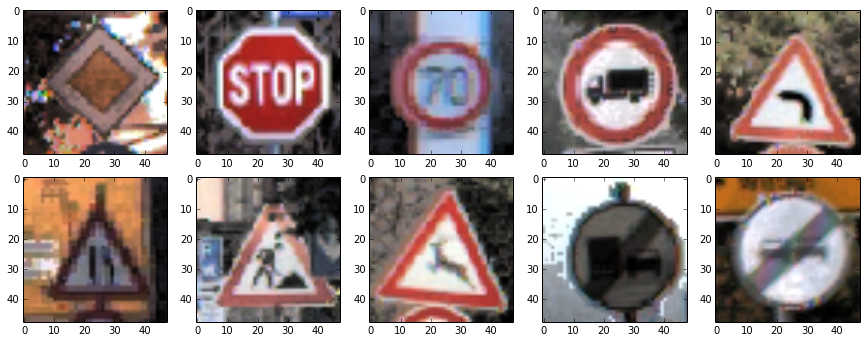

In [5]:
example_indices = (200,2500,3500,4900,5450,5500,6000,7700,8150,8300)
fig = plt.figure(figsize=(15,11))

for i in range(0,5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(X[example_indices[i]])
    fig.add_subplot(2,5,i+6)
    plt.imshow(X[example_indices[i+5]])

Now let's reduce palette to 4 colours

In [6]:
X_fewer_colours = reduce_palette(X)

/Users/pawelmorawiecki/tensorflow/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


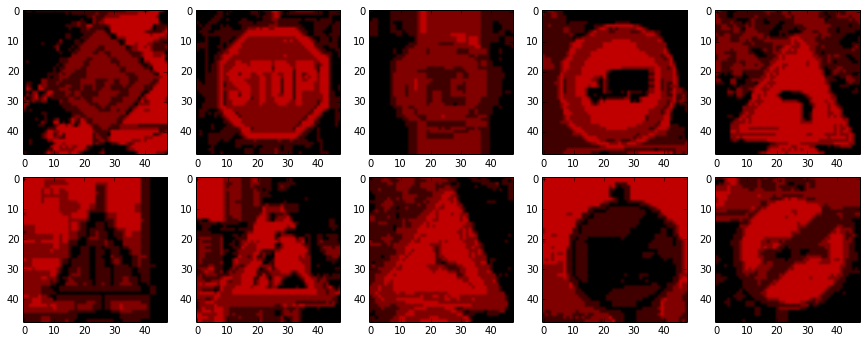

In [7]:
fig = plt.figure(figsize=(15,11))

for i in range(0,5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(X_fewer_colours[example_indices[i]])
    fig.add_subplot(2,5,i+6)
    plt.imshow(X_fewer_colours[example_indices[i+5]])

Change colours to pseudo-random values. In a given image the same colour is mapped to the same pseudo-random value. (it takes a few minutes to process all pictures)

In [8]:
X_random_colours = np.zeros((len(X), IMG_SIZE, IMG_SIZE, 3),dtype='float64')
for i in range(0,len(X)):
    prefix = hashlib.sha256(X_fewer_colours[i]).hexdigest() #hash is calculated using all pixels in a given image
    X_random_colours[i] = change_pixel_values(IMG_SIZE, X_fewer_colours[i], prefix)

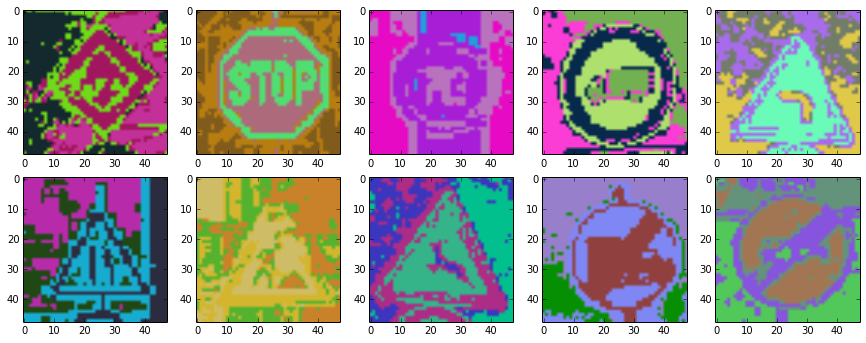

In [9]:
fig = plt.figure(figsize=(15,11))

for i in range(0,5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(X_random_colours[example_indices[i]])
    fig.add_subplot(2,5,i+6)
    plt.imshow(X_random_colours[example_indices[i+5]])

# Training

In [10]:
model = cnn_model(IMG_SIZE,NUM_CLASSES)

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.fit(X_random_colours, Y, batch_size=64, epochs=6)

Epoch 1/6
8520/8520 [==============================] - 91s - loss: 2.0074 - acc: 0.2408    
Epoch 2/6
8520/8520 [==============================] - 89s - loss: 1.4954 - acc: 0.4858    
Epoch 3/6
8520/8520 [==============================] - 94s - loss: 0.5746 - acc: 0.8116    
Epoch 4/6
8520/8520 [==============================] - 90s - loss: 0.3537 - acc: 0.8839    
Epoch 5/6
8520/8520 [==============================] - 89s - loss: 0.2621 - acc: 0.9141    
Epoch 6/6
8520/8520 [==============================] - 93s - loss: 0.2021 - acc: 0.9350    


In [ ]:
model.save_weights("random_colour_training.h5")

# Evaluation on the test set

In [13]:
X_test, Y_test = load_from_directory('test_set', IMG_SIZE, NUM_CLASSES)

In [14]:
X_test_fewer_colours = reduce_palette(X_test)

In [17]:
X_test_random_colours = np.zeros((len(X_test), IMG_SIZE, IMG_SIZE, 3),dtype='float64')
for i in range(0,len(X_test)):
    prefix = hashlib.sha256(X_test_fewer_colours[i]).hexdigest() #hash is calculated using all pixels in a given image
    X_test_random_colours[i] = change_pixel_values(IMG_SIZE, X_test_fewer_colours[i], prefix)

In [18]:
model.evaluate(X_test_random_colours, Y_test, batch_size=64)

2816/2820 [============================>.] - ETA: 0s

[0.34029205936066648, 0.8971631205673759]

# Regular model against adversarial examples

Adversarial examples were generated by Carlini-Wagner L2 attack with default parameters and confidence set to 20.
Let's first  see how a regular model deals with those examples.

In [19]:
adversarial_images, Y = load_from_directory('./adversarial_examples', IMG_SIZE, NUM_CLASSES)

Let's see some adversarial examples.

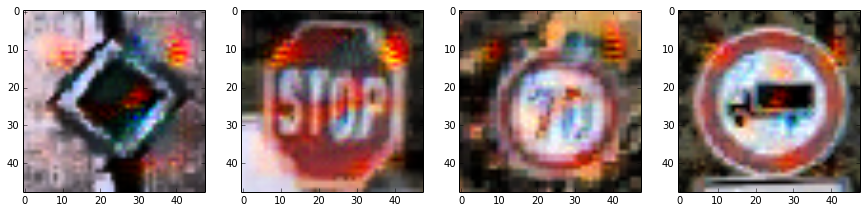

In [20]:
fig = plt.figure(figsize=(15,11))

for i in range(0,4):
    fig.add_subplot(1,4,i+1)
    plt.imshow(adversarial_images[i*5])

Now we calculate predictions by a regular classifier

In [21]:
K.clear_session()
K.set_learning_phase(0)

regular_model = cnn_model(IMG_SIZE,NUM_CLASSES)
regular_model.load_weights("./regular_training/regular_training.h5")

In [22]:
predictions = regular_model.predict_classes(adversarial_images)

20/20 [==============================] - 0s


In [23]:
labels = one_hot_encoding_to_label(Y)
for i in range(0,len(adversarial_images)):
    print ("Image %2d: true label %d, classified as %d"% (i,labels[i],predictions[i]))

Image  0: true label 0, classified as 9
Image  1: true label 0, classified as 9
Image  2: true label 0, classified as 9
Image  3: true label 0, classified as 9
Image  4: true label 1, classified as 9
Image  5: true label 1, classified as 9
Image  6: true label 1, classified as 9
Image  7: true label 1, classified as 9
Image  8: true label 2, classified as 9
Image  9: true label 2, classified as 9
Image 10: true label 2, classified as 9
Image 11: true label 2, classified as 9
Image 12: true label 3, classified as 9
Image 13: true label 3, classified as 9
Image 14: true label 3, classified as 9
Image 15: true label 3, classified as 9
Image 16: true label 4, classified as 9
Image 17: true label 4, classified as 9
Image 18: true label 4, classified as 9
Image 19: true label 4, classified as 9


All 20 adversarial examples fooled the regular model. Now let's see how our robust model deals with the these adversarial examples.

# Robust model against adversarial examples

In [24]:
robust_model = cnn_model(IMG_SIZE,NUM_CLASSES)
robust_model.load_weights("./random_colour_training.h5")

In [25]:
reduced = reduce_palette(adversarial_images) 

In [26]:
psuedorandom_colours = np.zeros((len(reduced), IMG_SIZE, IMG_SIZE, 3),dtype='float64')
for i in range(0,len(reduced)):
    prefix = hashlib.sha256(reduced[i]).hexdigest() #hash is calculated using all pixels in a given image
    psuedorandom_colours[i] = change_pixel_values(IMG_SIZE, reduced[i], prefix)

In [27]:
new_predictions = robust_model.predict_classes(psuedorandom_colours)

20/20 [==============================] - 0s


In [28]:
for i in range(0,len(adversarial_images)):
    print ("Image %2d: true label %d, classified as %d"% (i,labels[i],new_predictions[i]))

Image  0: true label 0, classified as 0
Image  1: true label 0, classified as 0
Image  2: true label 0, classified as 0
Image  3: true label 0, classified as 0
Image  4: true label 1, classified as 1
Image  5: true label 1, classified as 1
Image  6: true label 1, classified as 1
Image  7: true label 1, classified as 1
Image  8: true label 2, classified as 2
Image  9: true label 2, classified as 2
Image 10: true label 2, classified as 2
Image 11: true label 2, classified as 2
Image 12: true label 3, classified as 2
Image 13: true label 3, classified as 3
Image 14: true label 3, classified as 3
Image 15: true label 3, classified as 3
Image 16: true label 4, classified as 4
Image 17: true label 4, classified as 7
Image 18: true label 4, classified as 4
Image 19: true label 4, classified as 4


In [29]:
accuracy = ((labels==new_predictions).sum())/20.0

In [30]:
print ("Accuracy: %2.2f%%" % (accuracy*100.0))

Accuracy: 90.00%


# Visualizing convolutional filters

To get some insight how these two networks work, we visualize first 32 filters from the final convolutional layer. It is done by applying gradient descent with input image as a variable and maximizing the response of a specific filter. A starting point is a grey noisy image.

The regular model 'cares' much more about colours, whereas the robust model filters are maximized rather by concrete shapes and sharp lines than by intensity of specific colours. Regarding how the models were trained, this observation is what we would expect. Please see visualizations below. 

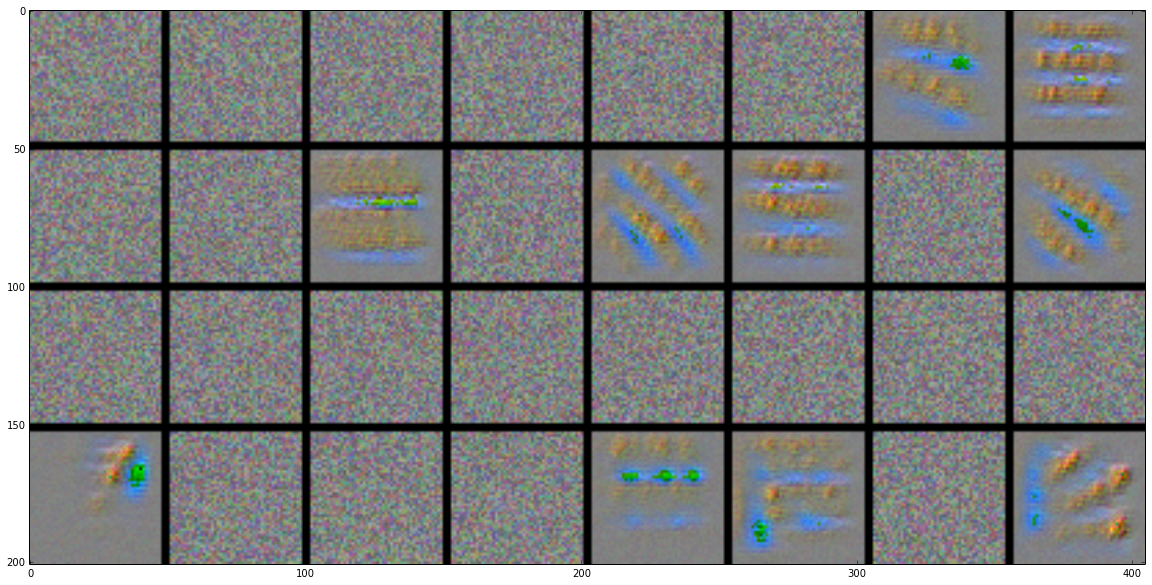

In [31]:
visualize_convolutional_filters(regular_model, 'final_conv_layer')

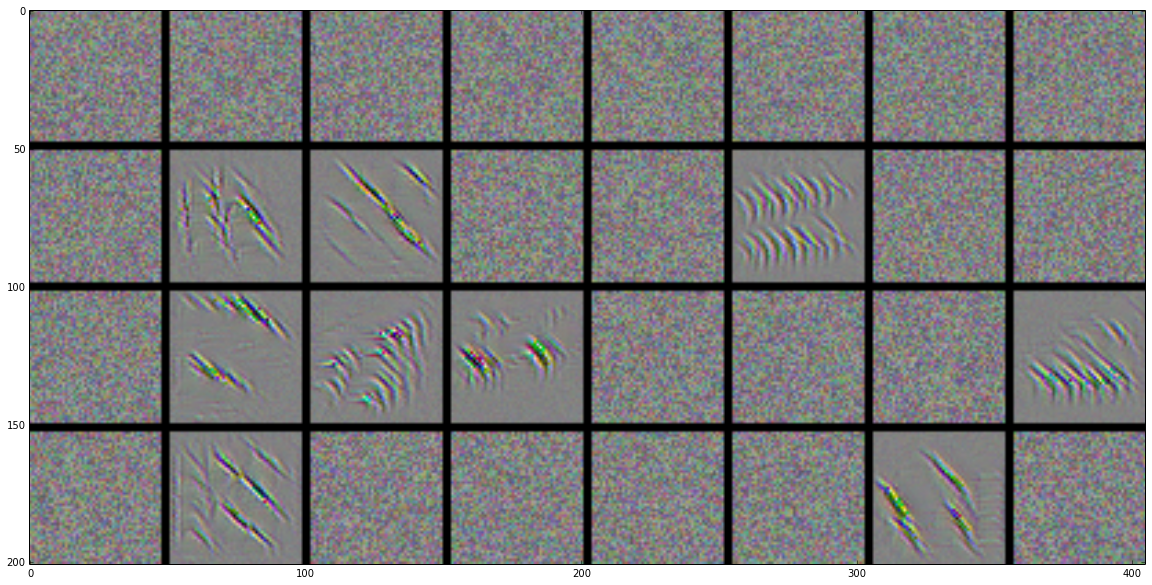

In [32]:
visualize_convolutional_filters(robust_model, 'final_conv_layer')